## Rx Gate

In [8]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler


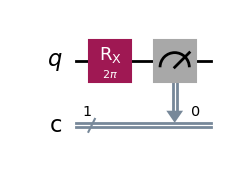

In [9]:
# Function to create a circuit with an Rx gate (decomposed as √X - Rz - √X)
def create_rx_circuit(beta):
    qc = QuantumCircuit(1, 1)
    qc.rx(2*beta,0)
    qc.measure(0,0)
    return qc

qc= create_rx_circuit(beta=np.pi)
qc.draw("mpl")

### RX gate investigation

In [10]:
# Load IBM noise model (replace with a different device if needed)
# backend = FakeBrisbane()  # Simulated IBMQ device
# noise_model = backend.properties()  # Extract noise properties


# Define rotation angles to test
beta_values = np.pi*np.linspace(0, 1, 50)  # Test 50 angles between 0 and π
repeat_num = 5 #  number of initialisations to do

service = QiskitRuntimeService(channel="ibm_quantum",
                               token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")
# Run simulations for each β
simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
ideal_simulator = AerSimulator()  # Ideal (noiseless) simulator
pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)
pm_ideal = generate_preset_pass_manager(optimization_level=1, backend=ideal_simulator)

def get_ideal_result(shots, rotation_angle):
    p_1 = np.sin(rotation_angle)**2
    n_1 = shots * p_1
    return n_1

count = 0
run = True
if run:
    error_rates_repeated = []
    for repeats in range(repeat_num):
        error_rates = []
        for beta in beta_values:
            qc = create_rx_circuit(beta)
            shots = 2**16
            # noise
            isa_qc = pm_noisy.run(qc)
            sampler = Sampler(mode=simulator)
            result_noise = sampler.run([isa_qc], shots=shots).result()
            
            # ideal
            isa_qc = pm_ideal.run(qc)
            sampler = Sampler(mode=ideal_simulator)
            result_ideal = sampler.run([isa_qc], shots=shots).result()
            
        
            p_noisy = result_noise[0].data.c.get_counts().get("1", 0) / shots
            p_ideal = np.sin(beta) ** 2

            error = abs(p_noisy - p_ideal)
            # error = p_noisy

            error_rates.append(error)
        error_rates_repeated.append(error_rates)

    err_rate_means = []
    err_rate_std = []
    for repeat in range(repeat_num):
        err_rate_means.append(np.mean(error_rates_repeated[repeat]))
        err_rate_std.append(np.std(error_rates_repeated[repeat]))

In [11]:
# structured this very weirdly so need to do it again
err_rate_means = []
err_rate_std = []
for i_beta in range(len(beta_values)):
    err_values = [error_rates_repeated[i][i_beta] for i in range(len(error_rates_repeated))]
    err_rate_means.append(np.mean(err_values))
    err_rate_std.append(np.std(err_values))


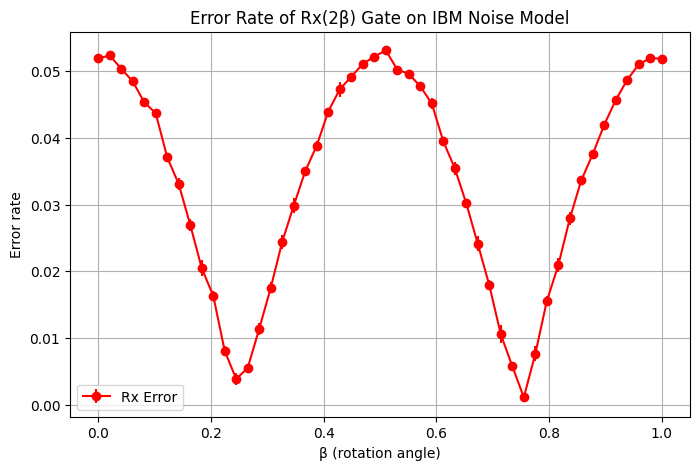

<Figure size 640x480 with 0 Axes>

In [12]:
# Plot results
plt.figure(figsize=(8, 5))
plt.errorbar(beta_values/np.pi, err_rate_means, yerr=np.array(err_rate_std)/2,
             marker="o", linestyle="-", color="r", label="Rx Error")
plt.xlabel("β (rotation angle)")
plt.ylabel("Error rate")
plt.title("Error Rate of Rx(2β) Gate on IBM Noise Model")
plt.legend()
plt.grid()
plt.show()
plt.savefig("loads_of_points_rx_error_theory_ideal.png", bbox_inches="tight")

In [14]:
import pandas as pd

for i_beta, beta in enumerate(beta_values):
    err_values = [error_rates_repeated[i][i_beta] for i in range(len(error_rates_repeated))]
    single_angle_dict = {"angle":[beta]*len(err_values), "error_rate":err_values}

    if i_beta == 0:
        output_df = pd.DataFrame(single_angle_dict)
    else:
        output_df = pd.concat([output_df, pd.DataFrame(single_angle_dict)])
output_df.reset_index(inplace=True, drop=True)
output_df.to_csv("data/2_processed/rx_investigation_results.csv", index=False)

## Post Analysis

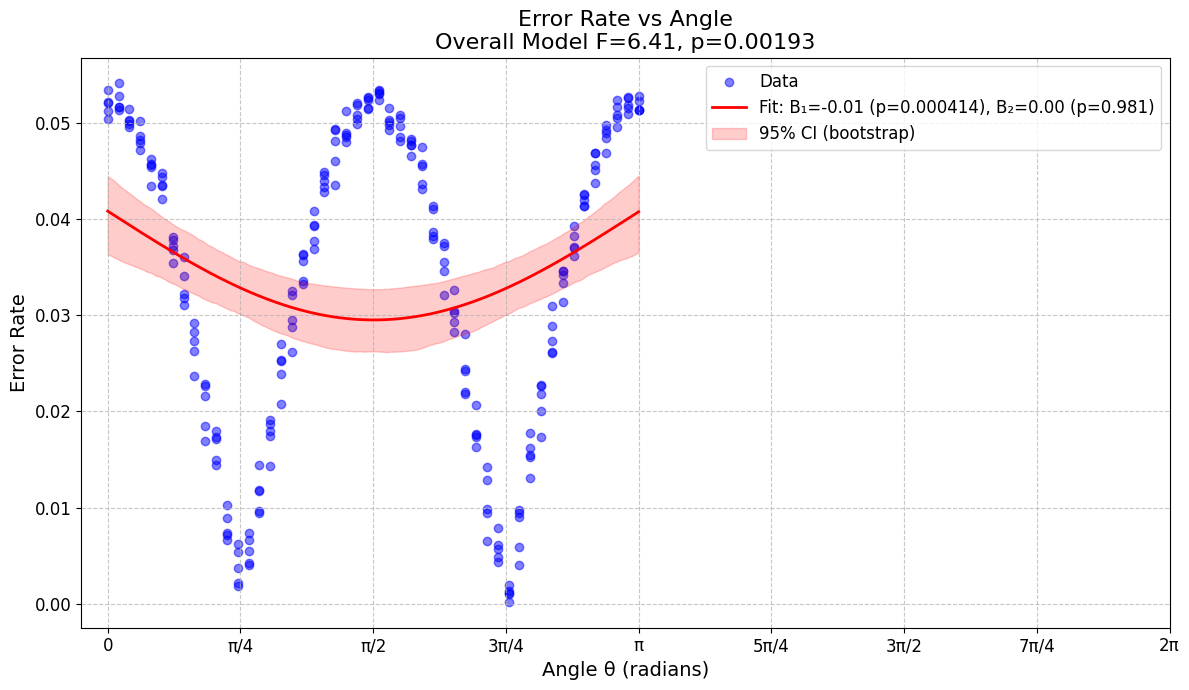

                            OLS Regression Results                            
Dep. Variable:             error_rate   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     6.409
Date:                Sat, 26 Apr 2025   Prob (F-statistic):            0.00193
Time:                        17:27:38   Log-Likelihood:                 682.87
No. Observations:                 250   AIC:                            -1360.
Df Residuals:                     247   BIC:                            -1349.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0408      0.002     18.485      0.0

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Load the data
data = pd.read_csv("data/2_processed/rx_investigation_results.csv")

# If your angles are in degrees, uncomment:
# data["angle"] = np.deg2rad(data["angle"])

# 2. Build predictors
data["sin_angle"] = np.sin(data["angle"])
data["cos_angle"] = np.cos(data["angle"])

X = data[["sin_angle", "cos_angle"]]
X = sm.add_constant(X)
y = data["error_rate"]

# 3. Fit the regression model
model = sm.OLS(y, X).fit()

# 4. Extract parameters
params = model.params
pvalues = model.pvalues

beta_0 = params["const"]
beta_1 = params["sin_angle"]
beta_2 = params["cos_angle"]

p_beta_1 = pvalues["sin_angle"]
p_beta_2 = pvalues["cos_angle"]

# Overall F-test
f_stat = model.fvalue
f_pvalue = model.f_pvalue

# 5. Predict over fine angle grid
angle_fine = np.linspace(0, np.pi, 500)
sin_fine = np.sin(angle_fine)
cos_fine = np.cos(angle_fine)

X_pred = np.column_stack((np.ones_like(angle_fine), sin_fine, cos_fine))
y_pred = X_pred @ params.values  # predicted mean

# 6. Bootstrap confidence intervals
n_bootstrap = 1000
y_bootstrap = np.zeros((n_bootstrap, len(angle_fine)))

np.random.seed(42)  # for reproducibility

for i in range(n_bootstrap):
    sample = data.sample(frac=1, replace=True)
    X_sample = sm.add_constant(sample[["sin_angle", "cos_angle"]])
    y_sample = sample["error_rate"]
    model_sample = sm.OLS(y_sample, X_sample).fit()
    params_sample = model_sample.params
    y_bootstrap[i] = X_pred @ params_sample.values

lower_bound = np.percentile(y_bootstrap, 2.5, axis=0)
upper_bound = np.percentile(y_bootstrap, 97.5, axis=0)

# 7. Plot
plt.figure(figsize=(12, 7))

# Raw data points
plt.scatter(data["angle"], data["error_rate"], color="blue", alpha=0.5, label="Data")

# Fitted curve
plt.plot(angle_fine, y_pred, color="red", lw=2, 
         label=f"Fit: B₁={beta_1:.2f} (p={p_beta_1:.3g}), B₂={beta_2:.2f} (p={p_beta_2:.3g})")

# Confidence bands
plt.fill_between(angle_fine, lower_bound, upper_bound, color="red", alpha=0.2, label="95% CI (bootstrap)")

plt.xlabel("Angle θ (radians)", fontsize=14)
plt.ylabel("Error Rate", fontsize=14)
plt.title(f"Error Rate vs Angle\nOverall Model F={f_stat:.2f}, p={f_pvalue:.3g}", fontsize=16)
plt.xticks(np.linspace(0, 2*np.pi, 9),
           ["0", "π/4", "π/2", "3π/4", "π", "5π/4", "3π/2", "7π/4", "2π"],
           fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 8. Print model summary (optional but highly recommended)
print(model.summary())


In [2]:
import statsmodels